In [1]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [115]:
def patient(env,i,p_length_of_stay):
    # add 1 to bed count while the patient is in the hospital
    glob_variables.patient_count+=1
    # patient takes up 1 bed=
    with beds.request() as req:
        yield req
        # trigger event when the patient is better
        yield env.timeout(p_length_of_stay)
    # reduce bed count after patient leaves
    glob_variables.patient_count-=1

def new_patient(env,infection_rate,carrying_capacity,length_of_stay):
    i = 0
    while True:
        i+=1
        # patient length of stay is drawn from exponential distribution
        p_length_of_stay = random.expovariate(1/length_of_stay)
        # create a new patient
        p = patient(env,i,p_length_of_stay)
        # start patient process
        env.process(p)
        # define next patient based on inter arrival time
        lambd = min(7, infection_rate*i*(1-(i/carrying_capacity)))
        next_p = random.expovariate(lambd)
        # trigger event when new patient comes
        yield env.timeout(next_p)

In [116]:
def check(env, delay):
    yield env.timeout(delay)
    while True:
        glob_variables.check_times.append(env.now)
        glob_variables.check_beds.append(beds.count)
        glob_variables.check_untreated.append(glob_variables.patient_count-beds.count)
        yield env.timeout(glob_variables.check_intervals)

In [117]:
class glob_variables:
    patient_count = 0
    infection_rate = 2
    carrying_capacity = 100000
    mean_length_of_stay = 14
    max_bed_capacity = 100
    sim_duration = 600
    check_times = []
    check_beds = []
    check_untreated = []
    check_intervals = 7
    delay = 7

In [118]:
env = simpy.Environment()
beds = simpy.Resource(env, capacity = glob_variables.max_bed_capacity)
env.process(new_patient(env,glob_variables.infection_rate,glob_variables.carrying_capacity,
                        glob_variables.mean_length_of_stay))
env.process(check(env,glob_variables.delay))
env.run(until=glob_variables.sim_duration)

In [119]:
Hospital_Ut = pd.DataFrame()
Hospital_Ut["Days Since Outbreak"] = glob_variables.check_times
Hospital_Ut["Bed Count"] = glob_variables.check_beds
Hospital_Ut["Untreated Patients"] = glob_variables.check_untreated

In [123]:
pd.set_option('display.max_rows',None)
Hospital_Ut

,Days Since Outbreak,Bed Count,Untreated Patients
0,7,40,0
1,14,73,0
2,21,95,0
3,28,99,0
4,35,89,0
5,42,84,0
6,49,80,0
7,56,100,2
8,63,100,1
9,70,93,0


In [93]:
def plot_graph(x,y):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(Hospital_Ut[x],Hospital_Ut[y])
    ax.set_xlabel(str(x))
    ax.set_ylabel(str(y))
    plt.xlim(0,glob_variables.sim_duration)
    plt.title("{} vs. {}".format(y,x),fontweight = "bold")

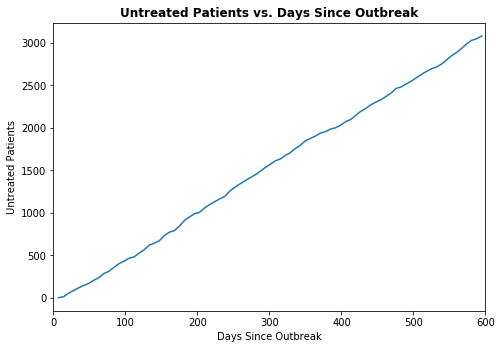

In [94]:
plot_graph("Days Since Outbreak","Untreated Patients")